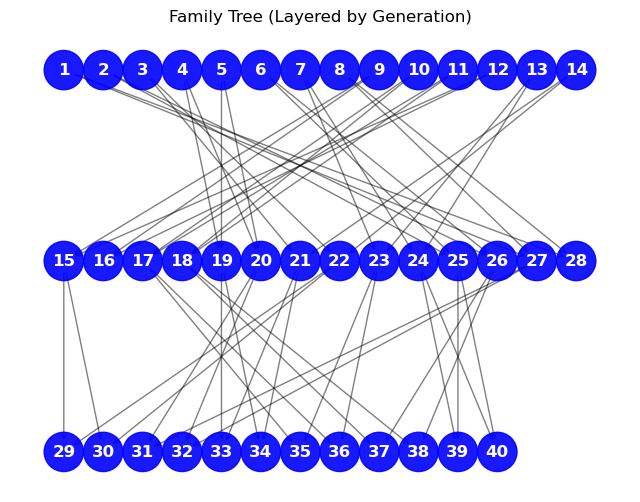

[{'id': 1, 'sex': 'F', 'father': None, 'mother': None, 'children': [27, 28], 'birth_year': 1950, 'geno': 'aa', 'death_age': 67.24576206006155}, {'id': 2, 'sex': 'M', 'father': None, 'mother': None, 'children': [25, 26], 'birth_year': 1950, 'geno': 'Aa', 'death_age': 120.0}, {'id': 3, 'sex': 'M', 'father': None, 'mother': None, 'children': [21, 22], 'birth_year': 1952, 'geno': 'AA', 'death_age': 86.93195673913866}, {'id': 4, 'sex': 'F', 'father': None, 'mother': None, 'children': [19, 20], 'birth_year': 1951, 'geno': 'Aa', 'death_age': 101.38516450914531}, {'id': 5, 'sex': 'M', 'father': None, 'mother': None, 'children': [19, 20], 'birth_year': 1952, 'geno': 'Aa', 'death_age': 88.11553655436997}, {'id': 6, 'sex': 'F', 'father': None, 'mother': None, 'children': [25, 26], 'birth_year': 1952, 'geno': 'aa', 'death_age': 98.70586308595516}, {'id': 7, 'sex': 'F', 'father': None, 'mother': None, 'children': [23, 24], 'birth_year': 1950, 'geno': 'aa', 'death_age': 89.89493723489429}, {'id': 8,

In [20]:
import numpy as np
from collections import defaultdict, deque
import math

##############################################################################
# 1. UTILITY: UNDIRECTED DISTANCE (BLOCK CLOSE RELATIVES)
##############################################################################

def build_undirected_adjacency(family):
    """
    Build an undirected adjacency: adj[pid] = set_of_neighbors 
    (parent<->child edges).
    """
    adj = {}
    for person in family:
        pid = person['id']
        adj[pid] = set()
    for person in family:
        pid = person['id']
        father = person['father']
        mother = person['mother']
        if father is not None:
            adj[pid].add(father)
            adj[father].add(pid)
        if mother is not None:
            adj[pid].add(mother)
            adj[mother].add(pid)
    return adj

def bfs_distance(adj, start, goal, max_search=9999):
    """
    Shortest undirected path length between 'start' and 'goal'
    or large number if > max_search or not connected.
    """
    if start == goal:
        return 0
    visited = {start}
    queue = deque([(start, 0)])
    while queue:
        curr, dist = queue.popleft()
        if curr == goal:
            return dist
        if dist < max_search:
            for nbr in adj[curr]:
                if nbr not in visited:
                    visited.add(nbr)
                    queue.append((nbr, dist+1))
    return 999999

def too_close(adj, p1, p2, dmax=4):
    """
    Return True if p1 and p2 are 'close relatives' => BFS distance <= dmax
    in the undirected adjacency.
    """
    dist = bfs_distance(adj, p1, p2, max_search=dmax+1)
    return (dist <= dmax)

##############################################################################
# 2. BUILD A LARGER FAMILY (~40 MEMBERS) IN 3 GENERATIONS
##############################################################################

def build_family_larger(dmax=4):
    """
    Build a 3-generation family of ~40 members:
      - G1: 14 people (7 father–mother couples)
      - G2: each G1 couple => 2 kids => 14 => total 28
      - G3: form G2 couples (distance check) => each => 2 kids => up to 14 => total ~42
    Also blocks close relatives if BFS distance <= dmax.

    Returns: list of person dicts, each with:
       'id', 'sex', 'father', 'mother', 'children',
       'birth_year', 'geno', 'death_age'
    """
    family = []
    next_id = 1

    #----------------------------------------------------------------
    #  GENERATION 1 => 14 people = 7 father–mother couples
    #----------------------------------------------------------------
    # Force 7 males, 7 females
    sexes = ['M']*7 + ['F']*7
    np.random.shuffle(sexes)

    G1_people = []
    for s in sexes:
        person = {
            'id': next_id,
            'sex': s,
            'father': None,
            'mother': None,
            'children': [],
            'birth_year': 1950 + np.random.randint(0,3),
            'geno': None,
            'death_age': None
        }
        family.append(person)
        G1_people.append(next_id)
        next_id += 1

    # Pair them => 7 couples
    males_g1 = [pid for pid in G1_people if family[pid-1]['sex']=='M']
    females_g1 = [pid for pid in G1_people if family[pid-1]['sex']=='F']
    np.random.shuffle(males_g1)
    np.random.shuffle(females_g1)
    G1_couples = list(zip(males_g1, females_g1))  # 7 father–mother couples

    # helper to create a child
    def create_child(father_id, mother_id, year_range=(1975,1980)):
        nonlocal next_id
        c_sex = np.random.choice(['M','F'])
        byear = np.random.randint(year_range[0], year_range[1])
        child = {
            'id': next_id,
            'sex': c_sex,
            'father': father_id,
            'mother': mother_id,
            'children': [],
            'birth_year': byear,
            'geno': None,
            'death_age': None
        }
        family.append(child)
        # link in parent's children
        family[father_id-1]['children'].append(next_id)
        family[mother_id-1]['children'].append(next_id)
        next_id += 1
        return child['id']

    #----------------------------------------------------------------
    #  GENERATION 2 => each G1 couple => 2 kids => total 14 => sum=28
    #----------------------------------------------------------------
    G2_people = []
    for (fa, mo) in G1_couples:
        for _ in range(2):
            c_id = create_child(fa, mo, year_range=(1975,1980))
            G2_people.append(c_id)

    #----------------------------------------------------------------
    #  GENERATION 3 => form G2 couples (distance check) => each => 2 kids
    #----------------------------------------------------------------
    id2p = {p['id']: p for p in family}
    males_g2 = [pid for pid in G2_people if id2p[pid]['sex']=='M']
    females_g2 = [pid for pid in G2_people if id2p[pid]['sex']=='F']
    np.random.shuffle(males_g2)
    np.random.shuffle(females_g2)

    G3_people = []
    while males_g2 and females_g2:
        father = males_g2.pop()
        # build adjacency
        adj = build_undirected_adjacency(family)
        mother_idx = None
        for i, mother in enumerate(females_g2):
            if not too_close(adj, father, mother, dmax=dmax):
                mother_idx = i
                break
        if mother_idx is not None:
            mother = females_g2.pop(mother_idx)
            for _ in range(2):
                c_id = create_child(father, mother, year_range=(2000,2005))
                G3_people.append(c_id)
        # else father remains single

    return family

##############################################################################
# 3. MENDELIAN GENOTYPE ASSIGNMENT
##############################################################################

def assign_genotypes_mendelian(family,
                               founder_probs={"AA":0.25, "Aa":0.5, "aa":0.25}):
    """
    Assign Mendelian genotype ("AA","Aa","aa") to each person:
      - Founders => sample from founder_probs
      - Children => inherits 1 allele from father + 1 from mother
    """
    id2person = {p['id']: p for p in family}
    waiting = {}
    from collections import deque
    queue = deque()

    # how many parents must we wait for each person
    for p in family:
        needed = 0
        if p['father'] is not None: needed+=1
        if p['mother'] is not None: needed+=1
        waiting[p['id']] = needed

    # founders => random genotype
    for p in family:
        if p['father'] is None and p['mother'] is None:
            p['geno'] = np.random.choice(list(founder_probs.keys()),
                                         p=list(founder_probs.values()))
            queue.append(p['id'])

    # BFS => once parent's genotype is set, we decrement child's waiting count
    while queue:
        parid = queue.popleft()
        par_gen = id2person[parid]['geno']
        # each child
        for c in id2person[parid]['children']:
            if waiting[c]>0:
                waiting[c]-=1
                if waiting[c]==0:
                    # assign child's genotype
                    child = id2person[c]
                    f_id = child['father']
                    m_id = child['mother']
                    f_geno = "AA" if f_id is None else id2person[f_id]['geno']
                    m_geno = "AA" if m_id is None else id2person[m_id]['geno']
                    child['geno'] = sample_child_geno(f_geno, m_geno)
                    queue.append(c)

def sample_child_geno(gdad, gmom):
    """
    father genotype=gdad, mother genotype=gmom => child inherits 1 allele from dad, 1 from mom
    => "AA","Aa","aa".
    """
    father_alleles = list(gdad)  # e.g. "Aa" => ['A','a']
    mother_alleles = list(gmom)
    import numpy as np
    fa = np.random.choice(father_alleles)
    ma = np.random.choice(mother_alleles)
    child_alleles = sorted([fa, ma])
    return "".join(child_alleles)  # e.g. ['A','a'] => "Aa"


##############################################################################
# 4. OPTIONAL: DEATH AGES
##############################################################################

def assign_natural_death_ages(family, mean_life=80):
    """
    Assign natural death ages from lognormal with median near mean_life.
    """
    for p in family:
        m = np.log(mean_life)
        s = 0.3
        age = np.random.lognormal(m, s)
        p['death_age'] = min(age,120.0)


def generate_time_varying_covariates(family, 
                                     max_age=100,
                                     covariates=('smoking','occupation','sports','eating','stress','depression')):
    """
    For each person in the 'family' list, build a yearly timeline from age=0
    up to their death_age (or 'max_age' if death_age is missing), and assign
    random or semi-random covariates (smoking status, occupation, etc.).

    Returns:
      tv_covars (dict):
        { person_id: [ (age, { 'smoking': ..., 'occupation': ..., ... }), ... ] }
      A list of (age, covariate_dict) for each year of that person's life.
    """
    # We'll collect a dictionary: pid -> list of (age, { covariates })
    tv_covars = {}

    for person in family:
        pid = person['id']
        birth_year = person.get('birth_year', 1970)
        # if we have 'death_age', use it; else use max_age
        d_age = person.get('death_age', None)
        if d_age is None:
            # use fallback
            d_age = max_age
        else:
            d_age = min(d_age, max_age)  # clamp to avoid huge loops

        # We'll store a list of (age, dict_of_covariates)
        timeline = []
        
        # Initialize covariates at age=0
        # You can define a “start” function for each covariate, or do random.
        current_covars = {}
        current_covars['smoking'] = 0  # 0=non-smoker, 1=smoker
        current_covars['occupation'] = np.random.choice(["Student","Unemployed","Manual","Office","Other"])
        current_covars['sports']     = np.random.choice(["None","Light","Moderate","Intense"])
        current_covars['eating']     = np.random.choice(["Healthy","Average","Junk"])
        current_covars['stress']     = np.random.randint(0, 4)  # from 0..3 at start
        current_covars['depression'] = 0  # 0=no, 1=yes
        
        # Record (age=0, current_covars)
        timeline.append( (0, current_covars.copy()) )

        # We'll iterate each year up to floor(d_age)
        for age in range(1, math.floor(d_age)+1):
            # We'll update each covariate in a simple random or rule-based way:

            # -- Smoking: some chance to start each year if currently non-smoker
            #            once started, remain smoker for simplicity
            if current_covars['smoking'] == 0:
                # probability that they start this year 
                # could be age-dependent, but we'll do a small constant chance
                if np.random.rand() < 0.02:
                    current_covars['smoking'] = 1
            
            # -- Occupation: maybe changes every ~10 years
            #   We'll do a random "job change" event
            if age % 10 == 0:
                current_covars['occupation'] = np.random.choice(["Unemployed","Manual","Office","Other"])
            
            # -- Sports: might change every few years
            if np.random.rand() < 0.1:
                current_covars['sports'] = np.random.choice(["None","Light","Moderate","Intense"])
            
            # -- Eating habits: might change every few years as well
            if np.random.rand() < 0.1:
                current_covars['eating'] = np.random.choice(["Healthy","Average","Junk"])
            
            # -- Stress: random walk but clamp 0..10
            #    e.g. each year can go up/down by 1 with some probability
            st = current_covars['stress']
            delta = np.random.choice([-1,0,1], p=[0.3,0.4,0.3])
            st_new = max(0, min(10, st + delta))
            current_covars['stress'] = st_new
            
            # -- Depression: random chance triggered by high stress (or spontaneously)
            #    e.g. if stress>7 => 20% chance depression=1, else 5% chance
            #    once depressed, we might revert to 0 next year with some chance
            if current_covars['depression'] == 0:
                if st_new > 7:
                    if np.random.rand() < 0.20:
                        current_covars['depression'] = 1
                else:
                    if np.random.rand() < 0.05:
                        current_covars['depression'] = 1
            else:
                # if currently depressed=1, chance to revert to 0
                if np.random.rand() < 0.3:
                    current_covars['depression'] = 0
            
            # record for this age
            timeline.append( (age, current_covars.copy()) )

        # store timeline in dictionary
        tv_covars[pid] = timeline

    return tv_covars



##############################################################################
# 5. DEMO
##############################################################################

if __name__=="__main__":
    np.random.seed(0)

    # 1) Build a 3-generation family ~40 members, block close relatives <=4
    fam = build_family_larger(dmax=4)

    # 2) Assign Mendelian genotype
    assign_genotypes_mendelian(fam, founder_probs={"AA":0.25,"Aa":0.5,"aa":0.25})

    # 3) Optionally assign death ages
    assign_natural_death_ages(fam, mean_life=80)
    
    # 4) generate time-varying covariates:
    tv_covariates = generate_time_varying_covariates(fam)

    visualize_family_tree(fam)
    # Print summary
    print(fam)
    print(tv_covariates)
    


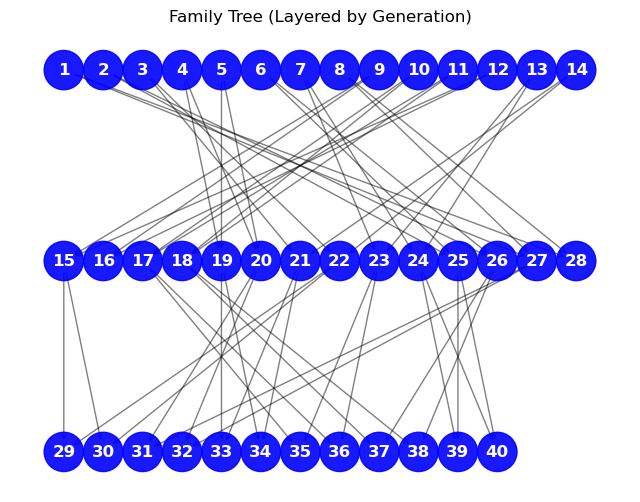

[{'id': 1, 'sex': 'F', 'father': None, 'mother': None, 'children': [27, 28], 'birth_year': 1950, 'geno': 'aa', 'death_age': 67.24576206006155}, {'id': 2, 'sex': 'M', 'father': None, 'mother': None, 'children': [25, 26], 'birth_year': 1950, 'geno': 'Aa', 'death_age': 120.0}, {'id': 3, 'sex': 'M', 'father': None, 'mother': None, 'children': [21, 22], 'birth_year': 1952, 'geno': 'AA', 'death_age': 86.93195673913866}, {'id': 4, 'sex': 'F', 'father': None, 'mother': None, 'children': [19, 20], 'birth_year': 1951, 'geno': 'Aa', 'death_age': 101.38516450914531}, {'id': 5, 'sex': 'M', 'father': None, 'mother': None, 'children': [19, 20], 'birth_year': 1952, 'geno': 'Aa', 'death_age': 88.11553655436997}, {'id': 6, 'sex': 'F', 'father': None, 'mother': None, 'children': [25, 26], 'birth_year': 1952, 'geno': 'aa', 'death_age': 98.70586308595516}, {'id': 7, 'sex': 'F', 'father': None, 'mother': None, 'children': [23, 24], 'birth_year': 1950, 'geno': 'aa', 'death_age': 89.89493723489429}, {'id': 8,

In [22]:
np.random.seed(0)

# 1) Build a 3-generation family ~40 members, block close relatives <=4
fam = build_family_larger(dmax=4)

# 2) Assign Mendelian genotype
assign_genotypes_mendelian(fam, founder_probs={"AA":0.25,"Aa":0.5,"aa":0.25})

# 3) Optionally assign death ages
assign_natural_death_ages(fam, mean_life=80)

# 4) generate time-varying covariates:
tv_covariates = generate_time_varying_covariates(fam)

visualize_family_tree(fam)
# Print summary
print(fam)
print(tv_covariates)